Here


c:\Users\Hardik\envs\final\Lib\site-packages\xgboost\core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-mlogloss:1.75931	test-mlogloss:1.75817
[1]	train-mlogloss:1.64166	test-mlogloss:1.64027
[2]	train-mlogloss:1.55318	test-mlogloss:1.55172
[3]	train-mlogloss:1.48377	test-mlogloss:1.48220
[4]	train-mlogloss:1.42891	test-mlogloss:1.42724
[5]	train-mlogloss:1.38425	test-mlogloss:1.38230
[6]	train-mlogloss:1.34419	test-mlogloss:1.34211
[7]	train-mlogloss:1.31105	test-mlogloss:1.30902
[8]	train-mlogloss:1.27919	test-mlogloss:1.27742
[9]	train-mlogloss:1.25187	test-mlogloss:1.25008
[10]	train-mlogloss:1.22549	test-mlogloss:1.22315
[11]	train-mlogloss:1.20207	test-mlogloss:1.20047
[12]	train-mlogloss:1.18144	test-mlogloss:1.17959
[13]	train-mlogloss:1.15992	test-mlogloss:1.15831
[14]	train-mlogloss:1.14235	test-mlogloss:1.14086
[15]	train-mlogloss:1.12551	test-mlogloss:1.12408
[16]	train-mlogloss:1.11008	test-mlogloss:1.10868
[17]	train-mlogloss:1.09234	test-mlogloss:1.09070
[18]	train-mlogloss:1.07721	test-mlogloss:1.07580
[19]	train-mlogloss:1.06334	test-mlogloss:1.06182
[20]	train

c:\Users\Hardik\envs\final\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:37:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4429
           1       0.99      0.99      0.99      6647
           2       0.97      0.98      0.97      6118
           3       0.96      0.97      0.96      8518
           4       0.97      0.96      0.96     10745
           5       0.98      0.98      0.98     12705
           6       1.00      0.94      0.97       591

    accuracy                           0.98     49753
   macro avg       0.98      0.97      0.98     49753
weighted avg       0.98      0.98      0.98     49753

Confusion Matrix:
 [[ 4413    16     0     0     0     0     0]
 [   13  6604    24     6     0     0     0]
 [    0    34  5984    92     8     0     0]
 [    5     5    74  8241   184     9     0]
 [    0    13    65   183 10288   196     0]
 [    0     0    29    82   163 12431     0]
 [    0     0     0     0     0    36   555]]


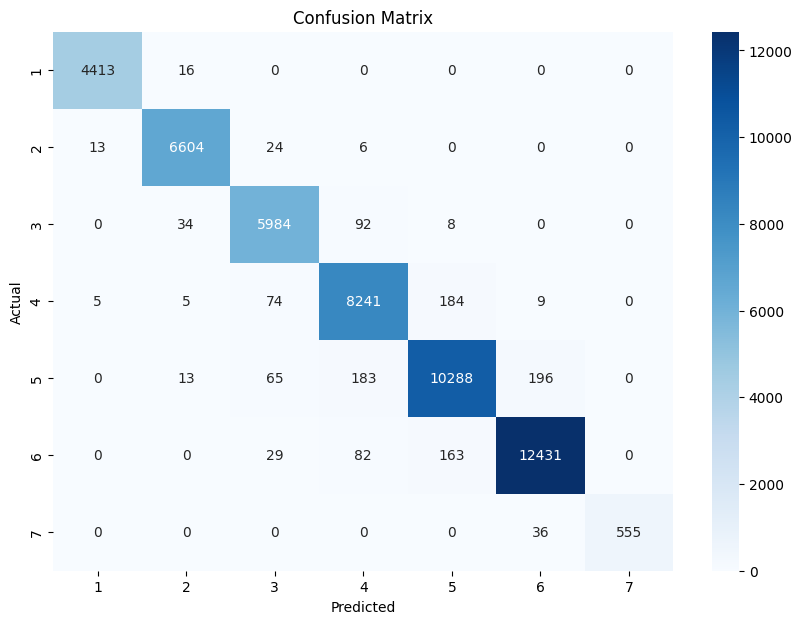

In [12]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file containing p-values
df = pd.read_csv('sorted_output_with_img_name.csv')  # Replace with the actual file path

# Drop unnecessary columns (adjust according to your column names)
df.drop('Image Name', axis=1, inplace=True)

X = df.iloc[:, :-1]
y = df.iloc[:, -1].astype(int) - 1 

# Identify and handle overlapping p-values
for col in X.columns:
    unique_values = X[col].unique()
    for value in unique_values:
        classes = df[df[col] == value]['Class Identifier'].unique()
        if len(classes) > 1:
            # Find the first class and adjust subsequent classes
            for idx, class_id in enumerate(classes):
                if idx == 0:
                    # First class retains the original value
                    continue
                else:
                    # Adjust subsequent classes by subtracting 0.01 from the original value
                    df.loc[(df[col] == value) & (df['Class Identifier'] == class_id), col] = value - 0.0001 * idx




# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("Here")


dtrain = xgb.DMatrix(X_train,y_train,enable_categorical=True)
dtest = xgb.DMatrix(X_test, y_test, enable_categorical=True)

params = {
    'max_depth':2,
    'eta':0.3,
    'objective':'multi:softprob',
    'num_class':7,
    'eval_metric': 'mlogloss'
}

# epoch=500
# eval_res={}
# evals = [(dtrain, 'train'), (dtest, 'test')]
# model = xgb.train(params,dtrain,epoch,evals,evals_result=eval_res)


epoch=500
eval_res={}
evals = [(dtrain, 'train'), (dtest, 'test')]
model = xgb.train(params,dtrain,epoch,evals,evals_result=eval_res)

# Make predictions using the trained model
y_pred_probs = model.predict(dtest)  # Get probabilities for each class

# Convert probabilities to class labels
y_pred = y_pred_probs.argmax(axis=1)  # Get class labels by taking argmax

# Save the model
model.save_model('xgboost_new.model')

# Print evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))  # Now y_pred is the predicted class labels
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Visualize confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4, 5, 6, 7], yticklabels=[1, 2, 3, 4, 5, 6, 7])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


